# Постановка задачи
Следует написать программу, которая:
* Запрашивает на вход размерность признакового пространства (в примере размерность равна 2 для иллюстрации)
* Запрашивает размер выборки (в примере он равен 100 для простоты)
* Иттерационно строит каскадный классификтор из линейных классификаторов. Каждый линейный классификатор обучается с помощью линейной регрессии.
* Вывести количество слоев каскада, определить итоговую точность и полноту

In [9]:
import math
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

In [10]:
def plot_results(positive_samples, negative_samples, weights, w0):
    import matplotlib.pyplot as plt
    %matplotlib inline

    for i in range(len(positive_samples)):   
        plt.scatter(positive_samples[i][0], positive_samples[i][1], c="green")
    for i in range(len(negative_samples)):        
        plt.scatter(negative_samples[i][0], negative_samples[i][1], c="red") 
    plt.xlabel("x1")
    plt.ylabel("x2")

    x = np.linspace(-3, 3, 100)
    y = [-(weights[0]*xi+w0)/weights[1] for xi in x]
    plt.plot(x, y)
    
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])

    plt.show()

In [11]:
class Cascade:
    def __init__(self, *args, **kwargs):
        self.__kwargs = kwargs
        self.__args = args
        self.__models = []
        
    @property
    def size(self): 
        return len(self.__models)
    
    def __getitem__(self, key):
        return self.__models[key]
    
    def __precision(self, weights, w0, positive_samples, negative_samples):
        tp = 0
        fp = 0
        for positive_sample in positive_samples:
            if np.dot(weights, positive_sample) + w0 > 0:
                tp = tp + 1
        for negative_sample in negative_samples:        
            if np.dot(weights, negative_sample) + w0 > 0:
                fp = fp + 1

        if tp + fp == 0: 
            return 0

        precision = tp / (tp + fp)

        return precision

    def __recall(self, weights, w0, positive_samples, negative_samples):
        tp = 0
        for positive_sample in positive_samples:
            if np.dot(weights, positive_sample) + w0 > 0:
                tp = tp + 1
        recall = tp / len(positive_samples)

        return recall
    
    def __find_optimal_w0(self, weights, w0, positive_samples, negative_samples):
        max_precision = 0
        opt_w0 = w0

        w0_all = np.linspace(w0, w0+50, 5000)
        for w0_i in w0_all:
            if (self.__recall(weights, w0_i, positive_samples, negative_samples) >= 0.99 
                and self.__precision(weights, w0_i, positive_samples, negative_samples) > max_precision):

                max_precision = self.__precision(weights, w0_i, positive_samples, negative_samples)
                opt_w0 = w0_i

        w0_all = np.linspace(w0, w0-50, 5000)   
        for w0_i in w0_all:
            if (self.__recall(weights, w0_i, positive_samples, negative_samples) >= 0.99 
                and self.__precision(weights, w0_i, positive_samples, negative_samples) > max_precision):

                max_precision = self.__precision(weights, w0_i, positive_samples, negative_samples)
                opt_w0 = w0_i

        return opt_w0
    
    def fit(self, samples, labels):
        
        if len(samples) != len(labels):
            raise KeyError("len(samples) != len(labels)")
        
        positive_samples = []
        negative_samples = []
        
        for i, label in enumerate(labels):
            if label == 1:
                positive_samples.append(samples[i])
            if label == -1:
                negative_samples.append(samples[i])
                    
        while negative_samples:

            logistic = LogisticRegression(*self.__args, **self.__kwargs)
            
            samples = positive_samples + negative_samples
            labels = [1] * len(positive_samples) + [-1] * len(negative_samples)

            logistic.fit(samples, labels)

            weights = logistic.coef_[0]
            w0 = logistic.intercept_[0]

            w0_new = self.__find_optimal_w0(weights, w0, positive_samples, negative_samples)
            logistic.intercept_[0] = w0_new
            
            self.__models.append(logistic) 

            new_negative_samples = []
            for sample in negative_samples:
                if np.dot(weights, sample) + w0_new >= 0:    
                    new_negative_samples.append(sample)
                    
            print("w1: ", weights[0], " w2: ", weights[1], " w0: ", w0, " w0_new: ", w0_new)
            print("kx+b  b(w0): ", -w0/weights[1], ' b(w0_new): ', -w0_new/weights[1])
            print('precision: ', self.__precision(weights, w0_new, positive_samples, negative_samples), 
                 ' recall: ', self.__recall(weights, w0_new, positive_samples, negative_samples))
            print("Size of new negative samples: ", len(new_negative_samples))
            
            plot_results(positive_samples, new_negative_samples, weights, w0_new)
            
            negative_samples = new_negative_samples.copy()
            
    def predict(self, samples):
        labels = [1] * len(samples)
        
        predicts = []    
        for model in self.__models:
            predicts.append(model.predict(samples))
            
        for i, _ in enumerate(samples):
            for j in range(self.size):
                if predicts[j][i] == -1:
                    labels[i] = -1

        return labels


In [12]:
def generate_sphere_sample(dim, r1, r2, count):
    samples = []
    for p in range(count): 
        r = random.uniform(r1, r2)
        point = [r] * dim
        
        for i in range(1, dim):           
            phi = random.uniform(0, math.pi)
            if i == 1: phi = random.uniform(0, 2*math.pi)
                
            for j in range(i):
                point[j] *= math.cos(phi)
            point[j+1] *= math.sin(phi)
        
        samples.append(point)
        
    return samples   

___

In [13]:
sample_count = 100

positive_samples = generate_sphere_sample(2, 0, 1, sample_count)
negative_samples = generate_sphere_sample(2, 1, 2, sample_count)

In [15]:
samples = positive_samples + negative_samples
labels = [1] * len(positive_samples) + [-1] * len(negative_samples)

w1:  0.16556750349275517  w2:  -0.1519025268793497  w0:  0.01038300711771299  w0_new:  0.18041701391907325
kx+b  b(w0):  0.0683530901757797  b(w0_new):  1.1877156860094336
precision:  0.5963855421686747  recall:  0.99
Size of new negative samples:  67


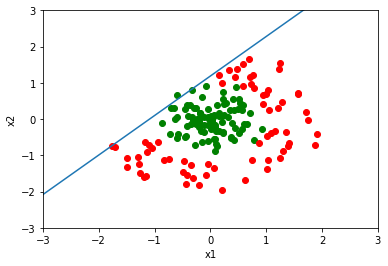

w1:  -0.8302971306458955  w2:  0.8617407537180154  w0:  0.6575915203792241  w0_new:  0.9976595339819446
kx+b  b(w0):  -0.7630966941531068  b(w0_new):  -1.1577258353832078
precision:  0.6971830985915493  recall:  0.99
Size of new negative samples:  43


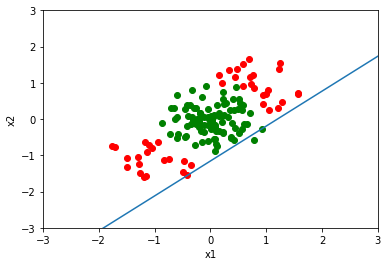

w1:  0.21805892389767453  w2:  -0.17395874781853185  w0:  0.8451979604355732  w0_new:  0.2350759360306921
kx+b  b(w0):  4.858611429631906  b(w0_new):  1.3513315023163752
precision:  0.7071428571428572  recall:  0.99
Size of new negative samples:  41


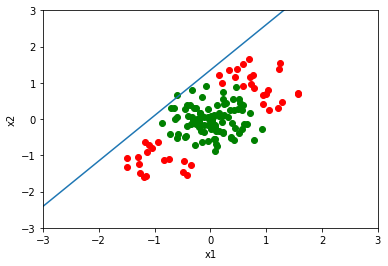

w1:  -0.001810283578825231  w2:  -0.12413139020267482  w0:  0.8925964742454399  w0_new:  0.11244044303919853
kx+b  b(w0):  7.190739367278963  b(w0_new):  0.9058179631728288
precision:  0.78125  recall:  1.0
Size of new negative samples:  28


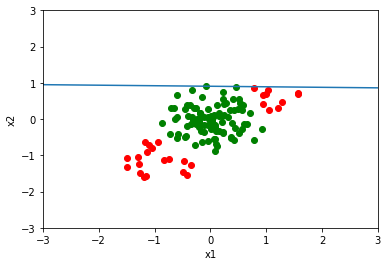

w1:  -0.18792146526977738  w2:  1.4808188070171644  w0:  1.6160794667731493  w0_new:  1.1459854479693885
kx+b  b(w0):  -1.0913418030045434  b(w0_new):  -0.7738863408128671
precision:  0.8761061946902655  recall:  0.99
Size of new negative samples:  14


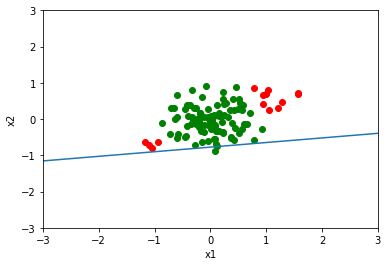

w1:  -1.2406821826554577  w2:  -0.5013259870118756  w0:  2.2644804966682197  w0_new:  1.3643004606610183
kx+b  b(w0):  4.516982074209885  b(w0_new):  2.7213838819584275
precision:  0.9615384615384616  recall:  1.0
Size of new negative samples:  4


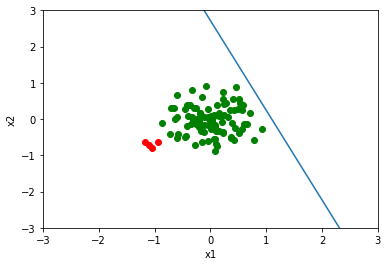

w1:  2.1725455903181925  w2:  1.3634522185635087  w0:  3.996188353672918  w0_new:  2.8859663092640364
kx+b  b(w0):  -2.930933918522777  b(w0_new):  -2.1166611267863877
precision:  1.0  recall:  1.0
Size of new negative samples:  0


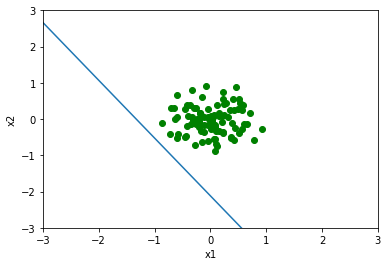

precision:  1.0  recall:  0.97


In [16]:
c = Cascade()
c.fit(samples, labels)
c.size
labels_pred = c.predict(samples)

print('precision: ', precision_score(labels, labels_pred), ' recall: ', recall_score(labels, labels_pred))

In [17]:
sample_count = 100

test_samples = generate_sphere_sample(2, 0, 1, sample_count) + generate_sphere_sample(2, 1, 2, sample_count)
test_labels = [1] * sample_count + [-1] * sample_count

test_labels_pred = c.predict(test_samples)

print('precision: ', precision_score(labels, test_labels_pred),
      ' recall: ', recall_score(labels, test_labels_pred))

precision:  0.9680851063829787  recall:  0.91
